# Define model

In [1]:
import pyprob
import numpy as np
import ot
import torch
import cProfile

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

import sklearn as skl
from sklearn.linear_model import LinearRegression

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = to_tensor(x)
    y = torch.stack(y)
    return sinkhorn(x,y)

def ot_dist(x,y):
    # x = torch.tensor(x)
    # y = torch.stack(y)
    x = np.array(x)
    y = np.array(torch.stack(y))
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    #Mat1 /= Mat1.max()
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
# obs_leaves = torch.tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
#        [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
#        [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
#        [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
#        [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
#        [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
#        [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
#        [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
#        [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
#        [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
#        [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
#        [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
#        [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
#        [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
#        [12.21401828,  6.76059035,  6.94920042,  7.42823701],
#        [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
#        [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
#        [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
#        [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
#        [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
#        [15.40023764,  9.10884407,  8.93836964,  8.61970667],
#        [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
#        [19.81054106, 11.90268453, 11.60989346, 10.76953856],
#        [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
#        [25.74331932, 15.63430056, 14.83860792, 14.07189108],
#        [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
#        [12.34604239,  7.78770185,  6.76075998,  6.78498685],
#        [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
#        [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
#        [16.28983576,  9.66683929,  9.24891886,  9.28970032],
#        [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
#        [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
#        [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
#        [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
#        [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]], dtype=torch.float64)


# QCD_mass = 30.
# #rate=torch.tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
# jetdir = np.array([1,1,1])
# jetP = 400.
# jetvec = jetP * jetdir / np.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# # Actual parameters
# pt_min = torch.tensor(0.3**2)
# M2start = torch.tensor(QCD_mass**2)
# jetM = np.sqrt(M2start.numpy()) ## Mass of initial jet
# jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))
# minLeaves = 1
# maxLeaves = 10000 # unachievable, to prevent rejections
# maxNTry = 100

# def dummy_bernoulli(self, jet):
#     return True

# class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
#     def forward(self, inputs=None):
#         assert inputs is None # Modify code if this ever not met?
#         # Sample parameter of interest from Unif(0,10) prior
#         root_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
#                             name="decay_rate_parameter")
#         decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
#                                    name="decay_rate_parameter")
#         # Simulator code needs two decay rates for (1) root note (2) all others
#         # For now both are set to the same value
#         inputs = [root_rate, decay_rate]
#         return super().forward(inputs)

# # Make instance of the simulator
# simulator = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
#                               pt_cut=float(pt_min),  # minimum pT for resulting jet
#                               Delta_0= M2start,  # parent particle mass squared -> needs tensor
#                               M_hard=jetM,  # parent particle mass
#                               minLeaves=1,  # minimum number of jet constituents
#                               maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
#                               bool_func=dummy_bernoulli,
#                               suppress_output=True,
#                               obs_leaves=obs_leaves)


In [3]:
def euclidean(a,b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.linalg.norm(a-b)

class GaussianUnknownMean(Model):
    def __init__(self, **kwargs):
        super().__init__(name='Gaussian with unknown mean', **kwargs) # give the model a name
        self.prior_mean = 1
        self.prior_std = math.sqrt(5)
        self.likelihood_std = math.sqrt(2)

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_std)) # NOTE: sample -> denotes latent variables

        # define the likelihood
        #likelihood = Normal(mu, self.likelihood_std)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        #pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables

        # return the latent quantity of interest
        return mu
    
class GaussianDIS(GaussianUnknownMean, ModelDIS):
    def __init__(self,  dist_fun = None, **kwargs):
        super().__init__(dist_fun = dist_fun)
        self.obs = 8
        #self.bool_func = bool_func
    def dummy_bernoulli(self, x):
        return True
    def forward(self):
        x = super().forward()
        likelihood = Normal(x, self.likelihood_std) 
        pyprob.observe(likelihood, name = 'sample_obs')
        delta_val = self.dummy_bernoulli(x)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return x


model = GaussianUnknownMean()
simulator = GaussianDIS(dist_fun = euclidean)

# Dataset test

In [4]:
dataset = OnlineDataset(simulator, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,importance_sample_size=5000)

/home/sragy/DISPyprob/pyprob/pyprob/model.py:182: UserWarning: No inference network found. Sampling from prior
  warnings.warn('No inference network found. Sampling from prior')


Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:15 | 0d:00:00:00 | #################### | 5000/5000 | 5000.00 | 330.04       


In [ ]:
trace = dataset[0]

In [9]:
results = np.array([i.result for i in dataset._semi_online_dataset])
weights = dataset._semi_online_dataset.weights_numpy()

(array([1.19658961e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.65950224e-18, 3.70256739e-16, 3.77663054e-11,
        2.05450145e-11, 2.62597053e-13, 2.53233105e-08, 1.32983762e-10,
        4.49990190e-08, 6.11886943e-09, 2.88624878e-07, 2.57218271e-08,
        1.97629396e-06, 2.28447890e-06, 9.82317631e-06, 5.06955068e-05,
        9.42796270e-05, 4.07073139e-04, 4.61618904e-04, 5.33708735e-04,
        2.22120301e-03, 1.71487900e-03, 3.05186219e-03, 4.85127340e-03,
        1.46086126e-02, 1.09650401e-02, 1.77297721e-02, 2.39787629e-02,
        3.74020786e-02, 5.21743608e-02, 4.73480816e-02, 6.11502657e-02,
        5.92935925e-02, 7.10637877e-02, 7.51820996e-02, 7.94663447e-02,
        7.19100970e-02, 7.05293014e-02, 9.71744709e-02, 5.36628934e-02,
        2.86269790e-02, 5.19654756e-02, 3.20521981e-02, 9.08013481e-03,
        1.06197031e-02, 1.06148795e-02]),
 array([-8.141929  , -7.8146634 , -7.4873977 , -7.1601324 , -6.8328667 ,
        -6.5056014 , 

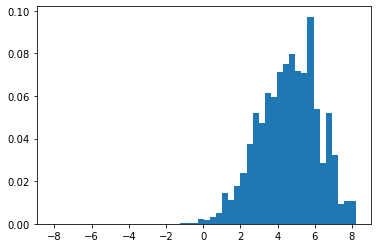

In [10]:
plt.hist(results, weights=weights,bins=50)

# Inference test

In [5]:
simulator.train(iterations = 20, importance_sample_size=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 350.08       
Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
Total addresses: 1, distribution types: 1, parameters: 1,505,093
0d:00:00:00 | 1    | 400       | +2.98e+00 | +2.74e+00 | +2.74e+00 | 0d:00:00:00 | +1.00e-03 | 1,255.0 
Stop condition reached. num_traces: 500
0d:00:00:00 | 1    | 500       | +2.98e+00 | +2.60e+00 | +2.60e+00 | 0d:00:00:00 | +1.00e-03 | 1,377.4 
Training iterations 1  epsi

In [6]:
results = simulator.posterior_results(num_traces=1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 1000/1000 |  11.65 | 127.22       


(array([  4.,   4.,  38., 110., 218., 295., 214.,  89.,  25.,   3.]),
 array([ 0.7284901,  1.6807522,  2.6330142,  3.5852761,  4.537538 ,
         5.4898   ,  6.442062 ,  7.3943243,  8.346586 ,  9.298848 ,
        10.25111  ], dtype=float32),
 <BarContainer object of 10 artists>)

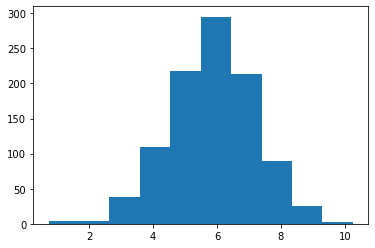

In [10]:
plt.hist(np.array(results))

# Posterior

Correct posterior

In [4]:
def plot_function(min_val, max_val, func, *args, **kwargs):
        x = np.linspace(min_val,max_val,int((max_val-min_val)*50))
        plt.plot(x, np.vectorize(func)(x), *args, **kwargs)

def get_dist_pdf(dist):
    return lambda x: math.exp(dist.log_prob(x))
        
class CorrectDistributions:
    def __init__(self, model):
        self.prior_mean = model.prior_mean
        self.prior_std = model.prior_std
        self.likelihood_std = model.likelihood_std
        self.prior_dist = Normal(self.prior_mean, self.prior_std)
        
    @property
    def observed_list(self):
        return self.__observed_list

    @observed_list.setter
    def observed_list(self, new_observed_list):
        self.__observed_list = new_observed_list
        self.construct_correct_posterior()
    
    def construct_correct_posterior(self):
        n = len(self.observed_list)
        posterior_var = 1/(n/self.likelihood_std**2 + 1/self.prior_std**2)
        posterior_mu = posterior_var * (self.prior_mean/self.prior_std**2 + n*np.mean(self.observed_list)/self.likelihood_std**2)
        self.posterior_dist = Normal(posterior_mu, math.sqrt(posterior_var))

    def prior_pdf(self, model, x):
        p = Normal(model.prior_mean,model.prior_stdd)
        return math.exp(p.log_prob(x))

    def plot_posterior(self, min_val, max_val):
        if not hasattr(self, 'posterior_dist'):
            raise AttributeError('observed values are not set yet, and posterior is not defined.')
        plot_function(min_val, max_val, get_dist_pdf(self.posterior_dist), label='correct posterior', color='orange')


    def plot_prior(self, min_val, max_val):
        plot_function(min_val, max_val, get_dist_pdf(self.prior_dist), label='prior', color='green')

correct_dists = CorrectDistributions(model)

In [5]:
prior = model.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 4,188.12       


In [6]:
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

NameError: name 'results' is not defined

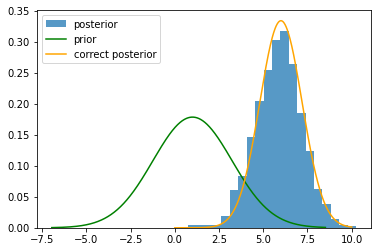

In [20]:
correct_dists.observed_list = [8]
plt.hist(np.array(unweighted_results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

In [21]:
results = simulator.posterior_results(num_traces=200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:02 | 0d:00:00:00 | #################### | 200/200 |  9.38 | 92.72        


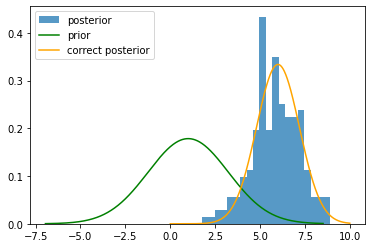

In [22]:
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

In [23]:
posterior = simulator.posterior(num_traces=200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 |  9.82 | 101.61       


In [26]:
unweighted = np.array([posterior.values[i].result for i in range(200)])

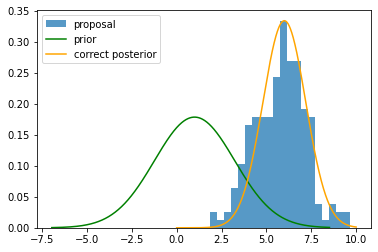

In [28]:
correct_dists.observed_list = [8]
plt.hist(np.array(unweighted), bins=20, alpha=0.75, label='proposal', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

# Delta Tests

In [7]:
def euclidean(a,b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.linalg.norm(a-b)

    
class GaussianDISDelta(GaussianUnknownMean, ModelDIS):
    def __init__(self,  dist_fun = None, **kwargs):
        super().__init__(dist_fun = dist_fun)
        self.obs = 8
        #self.bool_func = bool_func
    def dummy_bernoulli(self, x):
        return True
    def forward(self):
        x = super().forward()
        likelihood = Normal(x, self.likelihood_std) 
        val = pyprob.sample(likelihood)
        delta = Delta(val)
        pyprob.observe(delta, name = 'sample_obs')
        delta_val = self.dummy_bernoulli(x)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return x


simulatordelta = GaussianDISDelta(dist_fun = euclidean)

In [18]:
simulatordelta.train(iterations = 10, importance_sample_size=1000)

/home/sragy/DISPyprob/pyprob/pyprob/model.py:182: UserWarning: No inference network found. Sampling from prior
  warnings.warn('No inference network found. Sampling from prior')


Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 312.55       
Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
New layers, address: 28__forward__val__Normal__1, distribution: Normal
Total addresses: 2, distribution types: 1, parameters: 1,652,348
0d:00:00:00 | 1    | 300       | +4.25e+00 | +4.17e+00 | +4.20e+00 | 0d:00:00:00 | +1.00e-03 | 659.0                                 
Stop condition reached. num_traces: 500
0d:00:00:00 | 1    | 500      

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 1000/1000 |   1.54 | 72.44       


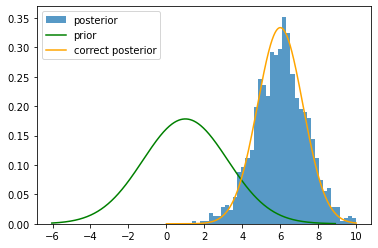

In [20]:
results = simulatordelta.posterior_results(num_traces=1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=40, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

In [ ]:
ind = np.argpartition(results.weights_numpy(), -4)[-4:]
results.weights_numpy()[ind]

# Weight truncation

In [8]:
simulatordeltatrunc = GaussianDISDelta(dist_fun = euclidean, weight_truncation = True)

In [9]:
simulatordeltatrunc.train(iterations = 10, importance_sample_size=1000)

/home/sragy/DISPyprob/pyprob/pyprob/model.py:220: UserWarning: No inference network found. Sampling from prior
  warnings.warn('No inference network found. Sampling from prior')


Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 1,229.73       
Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
New layers, address: 28__forward__val__Normal__1, distribution: Normal
Total addresses: 2, distribution types: 1, parameters: 1,652,348
0d:00:00:00 | 1    | 100       | +4.35e+00 | +4.35e+00 | +4.35e+00 | 0d:00:00:00 | +1.00e-03 | 16,621.0 
Stop condition reached. num_traces: 500
0d:00:00:00 | 1    | 500       | +4.35e+00 | +3.94e+00 | 

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:12 | 0d:00:00:00 | #################### | 1000/1000 |  19.75 | 78.31        


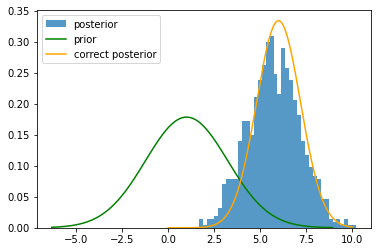

In [10]:
results = simulatordeltatrunc.posterior_results(num_traces=1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=40, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:20 | 0d:00:00:00 | #################### | 1000/1000 |   6.63 | 47.76       


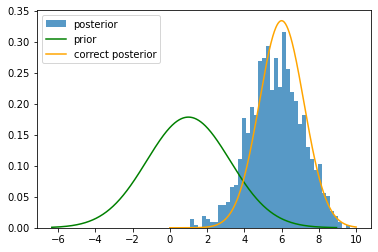

In [11]:
results = simulatordeltatrunc._dis_traces(num_traces=1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, map_func=lambda trace: trace.result, observe = {'dummy':1})
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=40, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

In [12]:
ind = np.argpartition(results.weights_numpy(), -4)[-4:]
results.weights_numpy()[ind]

array([0.00625305, 0.00636874, 0.00690823, 0.00656077])

# With ginkgo

In [5]:
obs_leaves = torch.tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
       [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
       [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
       [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
       [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
       [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
       [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
       [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
       [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
       [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
       [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
       [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
       [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
       [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
       [12.21401828,  6.76059035,  6.94920042,  7.42823701],
       [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
       [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
       [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
       [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
       [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
       [15.40023764,  9.10884407,  8.93836964,  8.61970667],
       [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
       [19.81054106, 11.90268453, 11.60989346, 10.76953856],
       [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
       [25.74331932, 15.63430056, 14.83860792, 14.07189108],
       [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
       [12.34604239,  7.78770185,  6.76075998,  6.78498685],
       [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
       [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
       [16.28983576,  9.66683929,  9.24891886,  9.28970032],
       [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
       [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
       [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
       [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
       [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]], dtype=torch.float64)


QCD_mass = 30.
#rate=torch.tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = np.array([1,1,1])
jetP = 400.
jetvec = jetP * jetdir / np.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = torch.tensor(0.3**2)
M2start = torch.tensor(QCD_mass**2)
jetM = np.sqrt(M2start.numpy()) ## Mass of initial jet
jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100



class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def dummy_bernoulli(self, jet):
        return True

    def forward(self, inputs=None):
        assert inputs is None # Modify code if this ever not met?
        # Sample parameter of interest from Unif(0,10) prior
        root_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                            name="decay_rate_parameter")
        decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                                   name="decay_rate_parameter")
        # Simulator code needs two decay rates for (1) root note (2) all others
        # For now both are set to the same value
        inputs = [root_rate, decay_rate]
        jet = super().forward(inputs)
        delta_val = self.dummy_bernoulli(jet)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return jet

# Make instance of the simulator
simulatorginkgo = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                              pt_cut=float(pt_min),  # minimum pT for resulting jet
                              Delta_0= M2start,  # parent particle mass squared -> needs tensor
                              M_hard=jetM,  # parent particle mass
                              minLeaves=1,  # minimum number of jet constituents
                              maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                              suppress_output=True,
                              obs_leaves=obs_leaves, 
                              dist_fun = sinkhorn_t,
                              weight_truncation = True)


In [3]:
#cProfile.run('simulatorginkgo.train(importance_sample_size=10)')
simulatorginkgo.train(iterations = 1, importance_sample_size=5000)

Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 32__forward__root_rate__Uniform__1, distribution: Uniform
New layers, address: 56__forward__decay_rate__Uniform__1, distribution: Uniform
New layers, address: 216__forward___traverse___traverse_rec__?__Uniform..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec__theta_CM_U..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec__draw_decay..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec__draw_decay..., distribution: TruncatedExponential
New

/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:303: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
Total addresses: 467, parameters: 238,176
------------------------------ | +5.30e+01 | +4.68e+01 | +4.68e+01 | 0d:00:00:00 | +1.00e-03 | 1.2  
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 

In [3]:
simulatorginkgo.load_inference_network('ginkgo_new_tests')

In [4]:
posterior_res = simulatorginkgo.posterior_results(num_traces = 200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,observe={'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___trave

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trave

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__15

------------------------------------------------ |  24/200 |  1.18 | 0.19       


/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:303: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------#----------------- |  27/200 |  1.18 | 0.19       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__16

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------########---------- | 104/200 |  4.34 | 0.19       


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:16:27 | 0d:00:00:04 | #################### | 200/200 |  6.61 | 0.20       


(array([20., 14., 24., 24., 20., 22., 16., 21., 25., 14.]),
 array([0.06516027, 1.05668   , 2.0481997 , 3.0397193 , 4.031239  ,
        5.0227585 , 6.0142784 , 7.0057983 , 7.997318  , 8.988837  ,
        9.980357  ], dtype=float32),
 <BarContainer object of 10 artists>)

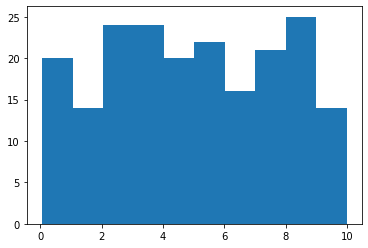

In [5]:
res = np.array([i['Lambda'].detach().numpy() for i in posterior_res])
plt.hist(res)

# Prior results

In [6]:
prior = simulatorginkgo.prior(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:02:43 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 6.12       


In [7]:
def get_leaves(trace):
    leaves = [j.value for j in trace.variables_observed]
    return leaves

In [8]:
distances = np.array([sinkhorn_t(obs_leaves, get_leaves(trace)).detach().numpy() for trace in prior])

(array([441., 223., 149.,  94.,  45.,  23.,  16.,   1.,   7.,   1.]),
 array([ 1.4324319,  7.5378056, 13.643179 , 19.748552 , 25.853926 ,
        31.9593   , 38.064674 , 44.170048 , 50.27542  , 56.380795 ,
        62.486168 ], dtype=float32),
 <BarContainer object of 10 artists>)

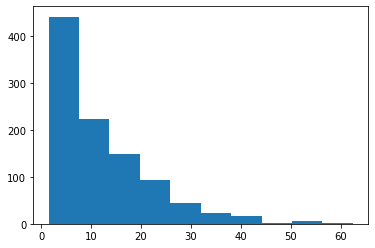

In [9]:
plt.hist(distances)

In [22]:
distances2 = np.array([ot_dist(obs_leaves, get_leaves(trace)).detach().numpy() for trace in prior])

(array([344., 247., 168.,  95.,  84.,  25.,  16.,  13.,   7.,   1.]),
 array([ 1.5837737,  7.9137654, 14.243757 , 20.573748 , 26.90374  ,
        33.23373  , 39.563725 , 45.893715 , 52.223705 , 58.5537   ,
        64.88369  ], dtype=float32),
 <BarContainer object of 10 artists>)

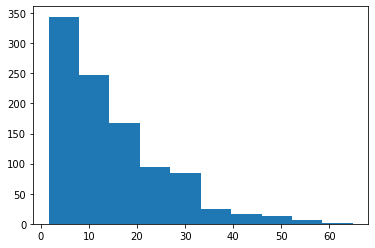

In [23]:
plt.hist(distances2)

In [30]:
def effective_sample_size(w):
    """Effective sample size of weights

    `w` is a 1-dimensional tensor of weights (normalised or unnormalised)"""
    sumw = torch.sum(w)
    if sumw == 0:
        return 0.

    return (sumw ** 2.0) / torch.sum(w ** 2.0)


def get_alternate_weights(sqd, old_weights, old_eps, new_eps):
    """Return weights appropriate to another `epsilon` value"""
    # Interpretable version of the generic reweighting code:
    # w = old_weights
    # d = torch.sqrt(sqd)
    # w /= torch.exp(-0.5*(d / old_eps)**2.)
    # w *= torch.exp(-0.5*(d / new_eps)**2.)
    # w /= sum(w)

    w = old_weights.detach().clone()
    if new_eps == 0:
        # Remove existing distance-based weight contribution
        w /= torch.exp(-0.5 * sqd / old_eps**2.)
        # Replace with indicator function weight contribution
        w = torch.where(
            sqd==0.,
            w,
            torch.zeros_like(w)
        )
    else:
        # An efficient way to do the generic case
        a = 0.5 * (old_eps**-2. - new_eps**-2.)
        w *= torch.exp(sqd*a)

    sumw = torch.sum(w)
    if sumw > 0.:
        w /= sumw
    return w


def find_eps(sqd, old_weights, old_eps, target_ess, upper, bisection_its=50):
        """Return epsilon value <= `upper` giving ess matching `target_ess` as closely as possible

        Bisection search is performed using `bisection_its` iterations
        """
        w = get_alternate_weights(sqd, old_weights, old_eps, upper)
        ess = effective_sample_size(w)
        if ess < target_ess:
            return upper

        lower = 0.
        for i in range(bisection_its):
            eps_guess = (lower + upper) / 2.
            w = get_alternate_weights(sqd, old_weights, old_eps, eps_guess)
            ess = effective_sample_size(w)
            if ess > target_ess:
                upper = eps_guess
            else:
                lower = eps_guess

        # Consider returning eps=0 if it's still an endpoint
        if lower == 0.:
            w = get_alternate_weights(sqd, old_weights, old_eps, 0.)
            ess = effective_sample_size(w)
            if ess > target_ess:
                return 0.

        # Be conservative by returning upper end of remaining range
        return upper

In [41]:
sqd1 = distances**2
sqd2 = distances2**2

In [36]:
find_eps(torch.tensor(sqd1), prior.weights, np.inf, 500, np.inf, bisection_its=50)

inf

In [38]:
find_eps(torch.tensor(sqd1), prior.weights, np.inf, 500, max(sqd1), bisection_its=50)

5.100730704432717

In [42]:
find_eps(torch.tensor(sqd2), prior.weights, np.inf, 500, max(sqd2), bisection_its=50)

6.522299582973038

In [51]:
def sinkhorn_2(x,y):
    x = torch.tensor(x)
    y = torch.tensor(y)
    return sinkhorn(x,y)
post_distances = np.array([sinkhorn_2(obs_leaves, res['leaves']).detach().numpy() for res in posterior_res])

/tmp/ipykernel_257/2585904463.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


(array([113.,  86.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 2.29035166,  6.35891559, 10.42747952, 14.49604345, 18.56460738,
        22.63317131, 26.70173524, 30.77029917, 34.8388631 , 38.90742703,
        42.97599096]),
 <BarContainer object of 10 artists>)

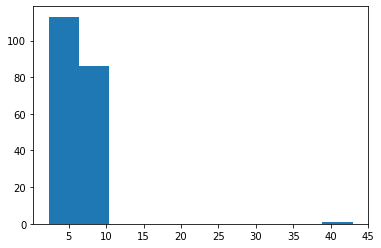

In [53]:
plt.hist(post_distances)

In [54]:
posterior_res2 = simulatorginkgo.posterior_results(num_traces = 200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,observe={'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__14

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___trave

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for

/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:349: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


/home/sragy/DISPyprob/pyprob/pyprob/model.py:66: UserWarning: Encountered trace with nan, inf, or -inf log_weight. Discarding trace.
  warnings.warn('Encountered trace with nan, inf, or -inf log_weight. Discarding trace.')


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__16

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for

------------------------------#######----------- |  88/200 |  1.97 | 0.27       


/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:303: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___travers

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:11:36 | 0d:00:00:03 | #################### | 200/200 |  3.99 | 0.29       


/tmp/ipykernel_257/2585904463.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


(array([ 8., 10., 18., 28., 35., 35., 35., 18., 11.,  1.]),
 array([2.3691599 , 3.12735789, 3.88555589, 4.64375388, 5.40195187,
        6.16014986, 6.91834785, 7.67654585, 8.43474384, 9.19294183,
        9.95113982]),
 <BarContainer object of 10 artists>)

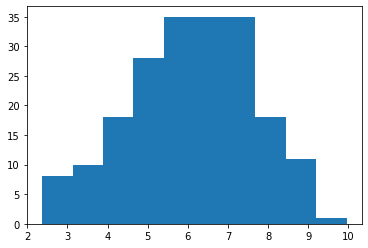

In [56]:
post_distances2 = np.array([sinkhorn_2(obs_leaves, res['leaves']).detach().numpy() for res in posterior_res2])
plt.hist(post_distances2)

In [7]:
for i in range(20):
    simulatorginkgo.train(iterations = 1, importance_sample_size=5000)
    simulatorginkgo.save_inference_network('inference_network_{}'.format(i))

Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 32__forward__root_rate__Uniform__1, distribution: Uniform
New layers, address: 56__forward__decay_rate__Uniform__1, distribution: Uniform
New layers, address: 216__forward___traverse___traverse_rec__?__Uniform..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec__theta_CM_U..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec__draw_decay..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec__draw_decay..., distribution: TruncatedExponential
New

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponenti

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponenti

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward__

------------------------------------------------ |   21/5000 |   1.00 | 0.38       


/home/tt21642/dispyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:303: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__14
  warnings.warn('Using prior. No propo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(add

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponenti

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserW

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponenti

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__17
  warnings.warn('Using prior. No propo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__2
  warnings.warn('Using prior. No propos

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec__draw_decay_R__TruncatedExponential__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No prop

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___t

------------------------------------------------ |  303/5000 |   1.81 | 0.36       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__1
  warning

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__18
  warnings.warn('Using prior. No propo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(add

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:349: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


/home/tt21642/dispyprob/pyprob/pyprob/model.py:66: UserWarning: Encountered trace with nan, inf, or -inf log_weight. Discarding trace.
  warnings.warn('Encountered trace with nan, inf, or -inf log_weight. Discarding trace.')


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob

------------------------------------------------ |  547/5000 |   6.02 | 0.35       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------##---------------- |  883/5000 |   9.15 | 0.34       
------------------------------##---------------- |  961/5000 |   9.91 | 0.34       
------------------------------##---------------- |  962/5000 |   9.91 | 0.34       
------------------------------##---------------- | 1003/5000 |  10.28 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserW

------------------------------###--------------- | 1240/5000 |  13.89 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec__draw_decay_L__TruncatedExponential__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------####-------------- | 1395/5000 |  15.16 | 0.34       
------------------------------####-------------- | 1542/5000 |   1.64 | 0.34       
------------------------------####-------------- | 1550/5000 |   1.64 | 0.34       
------------------------------#####------------- | 1672/5000 |   1.65 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_ne

------------------------------#####------------- | 1752/5000 |   1.66 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warning

------------------------------#######----------- | 2219/5000 |   2.51 | 0.34       
------------------------------#######----------- | 2349/5000 |   2.55 | 0.34       
------------------------------########---------- | 2434/5000 |   2.60 | 0.34       
------------------------------########---------- | 2452/5000 |   2.60 | 0.34       
------------------------------########---------- | 2487/5000 |   2.62 | 0.34       
------------------------------########---------- | 2536/5000 |   2.62 | 0.34       
------------------------------########---------- | 2570/5000 |   2.63 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___t

------------------------------#########--------- | 2733/5000 |   2.68 | 0.34       
------------------------------##########-------- | 2927/5000 |   3.20 | 0.34       
------------------------------##########-------- | 3077/5000 |   3.43 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___t

------------------------------############------ | 3565/5000 |   4.05 | 0.33       
------------------------------#############----- | 3657/5000 |   4.19 | 0.34       
------------------------------#############----- | 3818/5000 |   4.23 | 0.34       
------------------------------##############---- | 4122/5000 |   4.73 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: Use

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------################-- | 4422/5000 |   4.80 | 0.33       
------------------------------################-- | 4596/5000 |   4.85 | 0.33       
------------------------------#################- | 4680/5000 |   4.92 | 0.33       
0d:04:10:02 | 0d:00:00:03 | #################### | 5000/5000 |   5.17 | 0.33       
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___tra

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

------------------------------------------------ |  120/5000 |   3.01 | 0.35       
------------------------------
------------------------------------------------ |  163/5000 |   3.55 | 0.35       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------------------------ |  624/5000 |   8.30 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward

------------------------------#----------------- |  798/5000 |  11.80 | 0.33       
------------------------------##---------------- |  887/5000 |  13.12 | 0.33       
------------------------------##---------------- |  988/5000 |  14.52 | 0.33       
------------------------------##---------------- | 1028/5000 |  14.65 | 0.33       
------------------------------##---------------- | 1032/5000 |  14.65 | 0.33       
------------------------------##---------------- | 1070/5000 |  15.12 | 0.33       
------------------------------###--------------- | 1138/5000 |  15.84 | 0.33       
------------------------------####-------------- | 1463/5000 |  14.51 | 0.33       
------------------------------####-------------- | 1496/5000 |  14.65 | 0.33       
------------------------------####-------------- | 1532/5000 |  14.65 | 0.33       
------------------------------####-------------- | 1576/5000 |  15.41 | 0.33       
------------------------------#####------------- | 1722/5000 |  16.77 | 0.33

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------#######----------- | 2215/5000 |  22.38 | 0.33       
------------------------------#######----------- | 2366/5000 |  24.77 | 0.33       
------------------------------########---------- | 2550/5000 |  26.93 | 0.33       
------------------------------########---------- | 2556/5000 |  26.93 | 0.33       
------------------------------#########--------- | 2699/5000 |  27.73 | 0.33       
------------------------------##########-------- | 2886/5000 |  29.21 | 0.33       
------------------------------############------ | 3536/5000 |  34.50 | 0.33       
------------------------------#############----- | 3723/5000 |  35.40 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__19
  warnings.warn('Using prior. No propo

------------------------------##############---- | 3878/5000 |   1.50 | 0.33       
------------------------------##############---- | 3903/5000 |   1.51 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___t

------------------------------##############---- | 3975/5000 |   1.51 | 0.33       
------------------------------###############--- | 4287/5000 |   1.54 | 0.33       
------------------------------###############--- | 4321/5000 |   1.55 | 0.33       
------------------------------###############--- | 4365/5000 |   1.55 | 0.33       
------------------------------################-- | 4435/5000 |   1.56 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------#################- | 4754/5000 |   1.65 | 0.33       
0d:04:13:39 | 0d:00:00:03 | #################### | 5000/5000 |   1.67 | 0.33       
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
Total addresses: 648, parameters: 330,486
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniforme-03 | 2.0 
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
Total addresses: 652, parameters: 332,526
0d:08:48:31 | 1    | 1,400     | +4.89e+01 | +4.70e+01 | +4.85e+01 | 0d:04:18:15 | +1.00e-03 | 1.4 
Stop condition reached. num_traces: 500
0d:08:49:12 | 1    | 1,500     | +4.89e+01 | +4.70e+01 | +5.44e+01 |

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No prop

------------------------------------------------ |  186/5000 |   2.60 | 0.33       
------------------------------------------------ |  338/5000 |   3.28 | 0.34       
------------------------------------------------ |  395/5000 |   3.62 | 0.34       
------------------------------------------------ |  406/5000 |   4.16 | 0.34       
------------------------------#----------------- |  679/5000 |   6.85 | 0.33       
------------------------------#----------------- |  706/5000 |   6.92 | 0.33       
------------------------------#----------------- |  797/5000 |   7.35 | 0.34       
------------------------------##---------------- |  979/5000 |   8.19 | 0.34       
------------------------------##---------------- | 1008/5000 |   8.30 | 0.34       
------------------------------###--------------- | 1135/5000 |  10.30 | 0.34       
------------------------------###--------------- | 1161/5000 |  10.69 | 0.34       
------------------------------####-------------- | 1568/5000 |  15.03 | 0.34

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------######------------ | 2041/5000 |  19.09 | 0.34       
------------------------------######------------ | 2049/5000 |  19.14 | 0.34       
------------------------------#######----------- | 2337/5000 |  20.97 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------#########--------- | 2652/5000 |  24.60 | 0.34       
------------------------------#########--------- | 2703/5000 |  25.54 | 0.34       
------------------------------#########--------- | 2812/5000 |  26.06 | 0.34       
------------------------------#########--------- | 2815/5000 |  26.09 | 0.34       
------------------------------##########-------- | 2879/5000 |  27.10 | 0.34       
------------------------------##########-------- | 2955/5000 |  29.35 | 0.34       
------------------------------##########-------- | 2980/5000 |  29.36 | 0.34       
------------------------------##########-------- | 3078/5000 |   9.62 | 0.34       
------------------------------############------ | 3393/5000 |   9.62 | 0.34       
------------------------------############------ | 3446/5000 |   9.62 | 0.34       
------------------------------############------ | 3469/5000 |   9.62 | 0.34       
------------------------------#############----- | 3803/5000 |  11.08 | 0.34

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__22
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__22
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponenti

------------------------------###--------------- | 1136/5000 |   6.69 | 0.33       
------------------------------###--------------- | 1318/5000 |   7.47 | 0.33       
------------------------------######------------ | 1982/5000 |  13.06 | 0.33       
------------------------------######------------ | 2087/5000 |  13.89 | 0.33       
------------------------------#######----------- | 2323/5000 |  15.64 | 0.33       
------------------------------##########-------- | 2925/5000 |  21.52 | 0.33       
------------------------------###########------- | 3372/5000 |  24.41 | 0.33       
------------------------------############------ | 3411/5000 |  24.43 | 0.33       
------------------------------############------ | 3497/5000 |  25.42 | 0.33       
------------------------------############------ | 3539/5000 |  25.74 | 0.33       
------------------------------############------ | 3556/5000 |  25.75 | 0.33       
------------------------------#############----- | 3641/5000 |  27.24 | 0.33

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(add

------------------------------################## | 4939/5000 |  38.92 | 0.33       
0d:04:12:47 | 0d:00:00:03 | #################### | 5000/5000 |  39.14 | 0.33       
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponent

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__20
  warnings.warn('Using prior. No propo

------------------------------####-------------- | 1454/5000 |   7.84 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------####-------------- | 1529/5000 |   8.78 | 0.34       
------------------------------####-------------- | 1613/5000 |   9.78 | 0.33       
------------------------------#######----------- | 2180/5000 |   7.43 | 0.34       
------------------------------#######----------- | 2365/5000 |   7.88 | 0.33       
------------------------------#######----------- | 2371/5000 |   7.88 | 0.33       
------------------------------#########--------- | 2781/5000 |   9.23 | 0.34       
------------------------------#########--------- | 2815/5000 |   9.30 | 0.34       
------------------------------#########--------- | 2844/5000 |   9.44 | 0.34       
------------------------------##########-------- | 2922/5000 |   9.67 | 0.34       
------------------------------##########-------- | 3031/5000 |   9.98 | 0.34       
------------------------------##########-------- | 3102/5000 |  10.03 | 0.34       
------------------------------###########------- | 3208/5000 |  10.77 | 0.34

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_ne

------------------------------###########------- | 3307/5000 |  11.54 | 0.33       
------------------------------###########------- | 3342/5000 |  11.79 | 0.33       
------------------------------###########------- | 3362/5000 |  11.79 | 0.33       
------------------------------############------ | 3580/5000 |  12.41 | 0.33       
------------------------------#############----- | 3631/5000 |  12.46 | 0.33       
------------------------------#############----- | 3735/5000 |  12.64 | 0.33       
------------------------------##############---- | 3900/5000 |  12.79 | 0.33       
------------------------------##############---- | 3951/5000 |  13.14 | 0.33       
------------------------------##############---- | 3984/5000 |  13.19 | 0.33       
------------------------------###############--- | 4258/5000 |  14.30 | 0.33       
------------------------------################-- | 4406/5000 |  15.45 | 0.34       
------------------------------################-- | 4433/5000 |  15.54 | 0.34

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward

------------------------------------------------ |  113/5000 |   2.95 | 0.33       
------------------------------------------------ |  347/5000 |   2.17 | 0.33       
------------------------------------------------ |  348/5000 |   2.17 | 0.33       
------------------------------------------------ |  457/5000 |   2.61 | 0.34       
------------------------------------------------ |  488/5000 |   2.70 | 0.34       
------------------------------
------------------------------------------------ |  605/5000 |   2.81 | 0.33       
------------------------------#----------------- |  819/5000 |   3.68 | 0.33       
------------------------------##---------------- |  930/5000 |   3.89 | 0.33       
------------------------------##---------------- |  953/5000 |   3.89 | 0.33       
------------------------------###--------------- | 1132/5000 |   4.03 | 0.33       
------------------------------###--------------- | 1253/5000 |   4.19 | 0.33       
------------------------------###------------

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__22
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__22
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------###########------- | 3371/5000 |  11.98 | 0.33       
------------------------------############------ | 3401/5000 |  11.98 | 0.33       
------------------------------############------ | 3522/5000 |  12.47 | 0.33       
------------------------------##############---- | 3930/5000 |  13.22 | 0.33       
------------------------------##############---- | 3951/5000 |  13.40 | 0.33       
------------------------------##############---- | 4031/5000 |  13.45 | 0.33       
------------------------------###############--- | 4162/5000 |  13.83 | 0.33       
------------------------------################-- | 4414/5000 |  14.50 | 0.33       
------------------------------#################- | 4845/5000 |  15.92 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward

0d:04:10:51 | 0d:00:00:03 | #################### | 5000/5000 |  16.36 | 0.33       
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
Total addresses: 699, parameters: 356,496
1d:02:13:36 | 1    | 3,400     | +4.89e+01 | +4.70e+01 | +8.23e+01 | 0d:04:18:35 | +1.00e-03 | 0.9 
Stop condition reached. num_traces: 500
1d:02:15:50 | 1    | 3,500     | +4.89e+01 | +4.70e+01 | +7.50e+01 | 0d:04:20:49 | +1.00e-03 | 0.8 
Training iterations 1  epsilon 213.64  ESS 15.8
Continuing to train existing inference network...
Total number of parameters: 356,496
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min |

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: Use

------------------------------##---------------- |  917/5000 |   3.96 | 0.35       
------------------------------###--------------- | 1258/5000 |   6.81 | 0.34       
------------------------------###--------------- | 1372/5000 |   6.94 | 0.34       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob

------------------------------####-------------- | 1561/5000 |   7.82 | 0.34       
------------------------------#####------------- | 1828/5000 |   9.30 | 0.34       
------------------------------#######----------- | 2231/5000 |  10.63 | 0.34       
------------------------------########---------- | 2393/5000 |  10.75 | 0.34       
------------------------------########---------- | 2563/5000 |  12.14 | 0.34       
------------------------------#########--------- | 2656/5000 |  12.66 | 0.34       
------------------------------#########--------- | 2673/5000 |  12.66 | 0.34       
------------------------------#########--------- | 2676/5000 |  12.66 | 0.34       
------------------------------#########--------- | 2683/5000 |  12.74 | 0.34       
------------------------------##########-------- | 2885/5000 |  13.12 | 0.34       
------------------------------##########-------- | 2887/5000 |  13.12 | 0.34       
------------------------------##########-------- | 2905/5000 |  13.23 | 0.34

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warning

------------------------------#########--------- | 2739/5000 |   1.34 | 0.33       
------------------------------#########--------- | 2792/5000 |   1.35 | 0.33       
------------------------------##########-------- | 2896/5000 |   2.15 | 0.33       
------------------------------##########-------- | 2976/5000 |   2.17 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(add

------------------------------##########-------- | 3018/5000 |   2.18 | 0.33       
------------------------------###########------- | 3247/5000 |   2.19 | 0.33       
------------------------------###########------- | 3267/5000 |   2.19 | 0.33       
------------------------------############------ | 3412/5000 |   2.20 | 0.33       
------------------------------############------ | 3491/5000 |   2.23 | 0.33       
------------------------------############------ | 3574/5000 |   2.23 | 0.33       
------------------------------############------ | 3580/5000 |   2.23 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: Use

------------------------------#############----- | 3792/5000 |   2.30 | 0.33       
------------------------------#############----- | 3793/5000 |   2.30 | 0.33       
------------------------------#############----- | 3865/5000 |   2.30 | 0.33       
------------------------------##############---- | 3997/5000 |   2.31 | 0.33       
------------------------------##############---- | 4024/5000 |   2.31 | 0.33       
------------------------------##############---- | 4027/5000 |   2.31 | 0.33       
------------------------------##############---- | 4080/5000 |   2.32 | 0.33       
------------------------------###############--- | 4349/5000 |   2.39 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

------------------------------#################- | 4864/5000 |   2.44 | 0.33       
0d:04:12:02 | 0d:00:00:03 | #################### | 5000/5000 |   2.47 | 0.33       
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniforme-03 | 0.0 
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
Total addresses: 708, parameters: 361,086
1d:15:13:38 | 1    | 4,900     | +4.89e+01 | +4.70e+01 | +1.02e+02 | 0d:04:16:35 | +1.00e-03 | 2.2 
Stop condition reached. num_traces: 500
1d:15:14:19 | 1    | 5,000     | +4.89e+01 | +4.70e+01 | +1.04e+02 | 0d:04:17:17 | +1.00e-03 | 2.4 
Training iterations 1  epsilon 213.64  ESS 2.5
Continuing to train existing inference network...
Total number of paramete

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------##########-------- | 3017/5000 |   6.98 | 0.33       
------------------------------###########------- | 3141/5000 |   7.10 | 0.33       
------------------------------###########------- | 3154/5000 |   7.10 | 0.33       
------------------------------#############----- | 3773/5000 |   7.51 | 0.33       
------------------------------##############---- | 3953/5000 |   7.54 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/t

------------------------------###############--- | 4162/5000 |   7.65 | 0.33       
------------------------------###############--- | 4182/5000 |   7.65 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No prop

------------------------------################-- | 4485/5000 |   7.79 | 0.33       
------------------------------################-- | 4575/5000 |   8.12 | 0.33       
------------------------------#################- | 4785/5000 |   9.42 | 0.33       
0d:04:10:21 | 0d:00:00:03 | #################### | 5000/5000 |   9.53 | 0.33       
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniforme-03 | 0.0 
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___tra

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__23
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__23
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------###########------- | 3261/5000 |  18.89 | 0.34       
------------------------------############------ | 3407/5000 |  19.84 | 0.34       
------------------------------############------ | 3535/5000 |  20.76 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------#############----- | 3633/5000 |  20.81 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__th

------------------------------#############----- | 3849/5000 |  21.57 | 0.33       
------------------------------##############---- | 3986/5000 |  22.15 | 0.33       
------------------------------###############--- | 4129/5000 |  22.67 | 0.33       
------------------------------###############--- | 4257/5000 |  23.43 | 0.33       
------------------------------################-- | 4412/5000 |  23.94 | 0.33       
------------------------------################-- | 4615/5000 |  26.52 | 0.33       
------------------------------#################- | 4707/5000 |  26.65 | 0.33       
------------------------------#################- | 4745/5000 |  26.69 | 0.33       
------------------------------################## | 4937/5000 |  28.38 | 0.33       
0d:04:11:27 | 0d:00:00:03 | #################### | 5000/5000 |  28.52 | 0.33       
1d:23:56:12 | 1    | 5,900     | +4.89e+01 | +4.70e+01 | +1.04e+02 | 0d:04:22:46 | +1.00e-03 | 0.5 
Stop condition reached. num_traces: 500
1d:23:59:19 | 1    |

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------#################- | 4766/5000 |  12.79 | 0.33       
------------------------------#################- | 4864/5000 |  13.09 | 0.33       
------------------------------#################- | 4871/5000 |  13.11 | 0.33       
0d:04:13:40 | 0d:00:00:03 | #################### | 5000/5000 |  13.57 | 0.33       
2d:04:19:48 | 1    | 6,400     | +4.89e+01 | +4.70e+01 | +8.49e+01 | 0d:04:20:29 | +1.00e-03 | 0.9 
Stop condition reached. num_traces: 500
2d:04:21:40 | 1    | 6,500     | +4.89e+01 | +4.70e+01 | +8.56e+01 | 0d:04:22:21 | +1.00e-03 | 0.9 
Training iterations 1  epsilon 213.64  ESS 13.3
Continuing to train existing inference network...
Total number of parameters: 377,406
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------------------------ |   15/5000 |   1.00 | 0.36       
-----------------

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------###############--- | 4368/5000 |   3.06 | 0.34       
0d:04:07:51 | 0d:00:00:02 | #################### | 5000/5000 |   3.74 | 0.34       
2d:08:35:35 | 1    | 6,900     | +4.89e+01 | +4.70e+01 | +9.33e+01 | 0d:04:13:54 | +1.00e-03 | 1.2 
Stop condition reached. num_traces: 500
2d:08:36:57 | 1    | 7,000     | +4.89e+01 | +4.70e+01 | +9.15e+01 | 0d:04:15:16 | +1.00e-03 | 1.2 
Training iterations 1  epsilon 213.64  ESS 3.7
Continuing to train existing inference network...
Total number of parameters: 377,406
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------------------------ |  622/5000 |   4.31 | 0.34       
------------------------------#----------------- |  655/5000 |   4.86 | 0.34       
------------------------------###--------------- | 1282/5000 |  11.43 | 0.33       
------------------

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__5
  warning

------------------------------####-------------- | 1566/5000 |  13.04 | 0.33       
------------------------------####-------------- | 1609/5000 |  13.14 | 0.33       
------------------------------#####------------- | 1659/5000 |  13.95 | 0.33       
------------------------------#####------------- | 1670/5000 |  13.95 | 0.33       
------------------------------#####------------- | 1861/5000 |  15.95 | 0.33       
------------------------------######------------ | 2034/5000 |  17.54 | 0.33       
------------------------------######------------ | 2054/5000 |  17.56 | 0.33       
------------------------------########---------- | 2463/5000 |  11.32 | 0.33       
------------------------------########---------- | 2496/5000 |  12.46 | 0.33       
------------------------------########---------- | 2565/5000 |  13.03 | 0.33       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__20
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

------------------------------#########--------- | 2844/5000 |  16.81 | 0.33       
------------------------------##########-------- | 2876/5000 |  17.10 | 0.33       
------------------------------##########-------- | 3059/5000 |   6.31 | 0.33       
------------------------------###########------- | 3309/5000 |   6.73 | 0.33       
------------------------------###########------- | 3354/5000 |   6.78 | 0.33       
------------------------------############------ | 3385/5000 |   6.82 | 0.33       
------------------------------############------ | 3623/5000 |   7.47 | 0.33       
------------------------------#############----- | 3727/5000 |   7.79 | 0.33       
------------------------------##############---- | 3929/5000 |   7.97 | 0.33       
------------------------------##############---- | 4076/5000 |   8.23 | 0.33       
------------------------------##############---- | 4115/5000 |   8.31 | 0.33       
------------------------------###############--- | 4319/5000 |   8.78 | 0.33

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__23
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__23
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponenti

------------------------------
------------------------------###############--- | 4242/5000 |  31.30 | 0.33       
------------------------------################-- | 4503/5000 |  32.93 | 0.33       
------------------------------#################- | 4656/5000 |  34.25 | 0.33       
------------------------------#################- | 4820/5000 |  35.19 | 0.33       
0d:04:11:35 | 0d:00:00:03 | #################### | 5000/5000 |  35.49 | 0.33       
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniforme-03 | 0.0 
New layers, address: 260__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 470__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 520__forward___traverse___traverse_rec___traverse_..., distribution: TruncatedExponential
New layers, address: 216__forward___traverse___traverse_rec___traverse_..., distribution: Uniform
New layers, address: 2

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------#----------------- |  653/5000 |   5.73 | 0.35       
------------------------------#----------------- |  741/5000 |   6.05 | 0.35       
------------------------------#----------------- |  746/5000 |   6.32 | 0.35       
------------------------------##---------------- |  898/5000 |   7.07 | 0.34       
------------------------------##---------------- |  921/5000 |   7.11 | 0.34       
------------------------------##---------------- |  931/5000 |   7.11 | 0.34       
------------------------------##---------------- |  992/5000 |   7.34 | 0.34       
------------------------------##---------------- | 1124/5000 |   8.03 | 0.34       
------------------------------###--------------- | 1236/5000 |   9.64 | 0.34       
------------------------------###--------------- | 1300/5000 |  10.69 | 0.34       
------------------------------####-------------- | 1620/5000 |  12.71 | 0.34       
------------------------------######------------ | 1992/5000 |  15.34 | 0.34

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------################-- | 4476/5000 |  31.98 | 0.33       
------------------------------################-- | 4522/5000 |  32.08 | 0.33       
------------------------------#################- | 4847/5000 |  34.80 | 0.33       
------------------------------################## | 4875/5000 |  34.80 | 0.33       
------------------------------################## | 4927/5000 |  35.02 | 0.33       
------------------------------################## | 4953/5000 |  35.31 | 0.33       
0d:04:11:00 | 0d:00:00:03 | #################### | 5000/5000 |  35.52 | 0.33       
2d:21:44:56 | 1    | 8,400     | +4.89e+01 | +4.70e+01 | +9.46e+01 | 0d:04:21:22 | +1.00e-03 | 0.7 
Stop condition reached. num_traces: 500
2d:21:47:34 | 1    | 8,500     | +4.89e+01 | +4.70e+01 | +9.46e+01 | 0d:04:24:00 | +1.00e-03 | 0.6 
Training iterations 1  epsilon 213.64  ESS 34.3
Continuing to train existing inference network...
Total number of parameters: 391,686
Train. time | Epoch| Trace     | Init.

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__22
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__22
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

------------------------------##---------------- |  923/5000 |  10.32 | 0.33       
------------------------------##---------------- |  961/5000 |  10.67 | 0.33       
------------------------------##---------------- |  963/5000 |  10.67 | 0.33       
------------------------------###--------------- | 1172/5000 |  12.16 | 0.33       
------------------------------#####------------- | 1677/5000 |  20.82 | 0.32       
------------------------------#####------------- | 1716/5000 |  21.56 | 0.33       
------------------------------#####------------- | 1756/5000 |   4.93 | 0.33       
------------------------------######------------ | 1934/5000 |   5.03 | 0.33       
------------------------------########---------- | 2478/5000 |   8.87 | 0.33       
------------------------------########---------- | 2573/5000 |   9.90 | 0.33       
------------------------------########---------- | 2608/5000 |  10.00 | 0.33       
------------------------------############------ | 3403/5000 |  11.31 | 0.33

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


------------------------------################-- | 4503/5000 |  14.57 | 0.33       
------------------------------################## | 4964/5000 |  14.20 | 0.33       
0d:04:13:21 | 0d:00:00:03 | #################### | 5000/5000 |  14.22 | 0.33       
3d:06:36:07 | 1    | 9,400     | +4.89e+01 | +4.70e+01 | +9.45e+01 | 0d:04:21:15 | +1.00e-03 | 0.9 
Stop condition reached. num_traces: 500
3d:06:37:59 | 1    | 9,500     | +4.89e+01 | +4.70e+01 | +9.90e+01 | 0d:04:23:07 | +1.00e-03 | 0.9 
Training iterations 1  epsilon 213.64  ESS 14.0
Continuing to train existing inference network...
Total number of parameters: 393,726
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------------------------ |  318/5000 |   3.78 | 0.34       
------------------------------------------------ |  323/5000 |   4.13 | 0.34       
-----------------

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__21
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

------------------------------##########-------- | 2888/5000 |   6.13 | 0.34       
------------------------------##########-------- | 2961/5000 |   6.21 | 0.34       
------------------------------##########-------- | 2967/5000 |   6.21 | 0.34       
------------------------------##########-------- | 2982/5000 |   6.21 | 0.34       
------------------------------##########-------- | 3073/5000 |   6.33 | 0.34       
------------------------------##########-------- | 3112/5000 |   6.33 | 0.34       
------------------------------############------ | 3527/5000 |   7.18 | 0.34       
------------------------------############------ | 3566/5000 |   7.31 | 0.34       
------------------------------##############---- | 4103/5000 |   9.11 | 0.34       
------------------------------###############--- | 4176/5000 |   9.15 | 0.34       
------------------------------###############--- | 4271/5000 |   9.20 | 0.34       
------------------------------################-- | 4420/5000 |  10.69 | 0.34

In [6]:
for i in range(10):
    print('inference_network_{}'.format(i))

inference_network_0
inference_network_1
inference_network_2
inference_network_3
inference_network_4
inference_network_5
inference_network_6
inference_network_7
inference_network_8
inference_network_9


In [8]:
posterior_results = simulatorginkgo.posterior_results(num_traces = 200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,observe={'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec
0d:00:09:34 | 0d:00:00:02 | #################### | 200/200 |  3.86 | 0.35       


In [9]:
def sinkhorn_2(x,y):
    x = torch.tensor(x)
    y = torch.tensor(y)
    return sinkhorn(x,y)
posterior_distances = np.array([sinkhorn_2(obs_leaves, res['leaves']).detach().numpy() for res in posterior_results])

/tmp/ipykernel_70602/1752891521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


(array([ 7., 15., 37., 53., 55., 26.,  6.,  0.,  0.,  1.]),
 array([ 2.18559314,  3.22246649,  4.25933984,  5.29621319,  6.33308653,
         7.36995988,  8.40683323,  9.44370658, 10.48057993, 11.51745328,
        12.55432663]),
 <BarContainer object of 10 artists>)

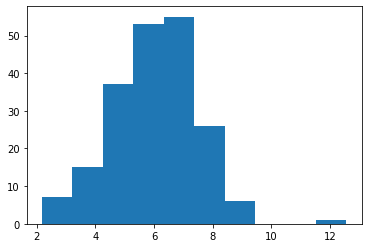

In [10]:
plt.hist(posterior_distances)

In [11]:
lambdas = np.array([i['Lambda'].detach().numpy() for i in posterior_results])

(array([22., 14., 20., 21., 18., 19., 23., 21., 24., 18.]),
 array([0.01044607, 1.0014656 , 1.992485  , 2.9835045 , 3.974524  ,
        4.9655437 , 5.956563  , 6.9475822 , 7.938602  , 8.929622  ,
        9.920641  ], dtype=float32),
 <BarContainer object of 10 artists>)

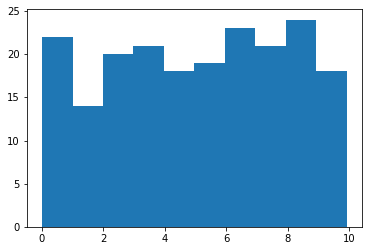

In [12]:
plt.hist(lambdas)

In [13]:
def leaf_dist(x,y):
    x_count = len(x)
    y_count = len(y)
    return np.abs(x_count-y_count)

In [14]:
simulatorginkgoleaf = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                              pt_cut=float(pt_min),  # minimum pT for resulting jet
                              Delta_0= M2start,  # parent particle mass squared -> needs tensor
                              M_hard=jetM,  # parent particle mass
                              minLeaves=1,  # minimum number of jet constituents
                              maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                              suppress_output=True,
                              obs_leaves=obs_leaves,
                              dist_fun = leaf_dist)

In [17]:
simulatorginkgoleaf.train(iterations = 1, importance_sample_size = 5000)

Continuing to train existing inference network...
Total number of parameters: 231,036
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(add

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___tra

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 520__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___tra

------------------------------------------------ |   44/5000 |   1.11 | 0.36       


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 470__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__?__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 260__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob

------------------------------------------------ |  322/5000 |   3.08 | 0.35       
------------------------------------------------ |  522/5000 |   4.55 | 0.35       
------------------------------#----------------- |  802/5000 |   3.93 | 0.35       
------------------------------##---------------- |  933/5000 |   4.35 | 0.35       
------------------------------##---------------- |  955/5000 |   4.40 | 0.35       
------------------------------###--------------- | 1266/5000 |   7.08 | 0.35       
------------------------------#####------------- | 1646/5000 |   9.94 | 0.35       
------------------------------#####------------- | 1772/5000 |  10.21 | 0.35       
------------------------------######------------ | 1973/5000 |  11.96 | 0.35       
------------------------------#######----------- | 2150/5000 |  14.00 | 0.35       
------------------------------#######----------- | 2243/5000 |  14.50 | 0.35       
------------------------------#######----------- | 2285/5000 |  14.50 | 0.35

In [18]:
leaf_results = simulatorginkgoleaf.posterior_results(num_traces = 200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,observe={'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec
------------------------------------------------ |  23/200 |  1.02 | 0.32       
------------------------------###############--- | 174/200 |  2.19 | 0.31       
0d:00:10:34 | 0d:00:00:03 | #################### | 200/200 |  2.32 | 0.32       


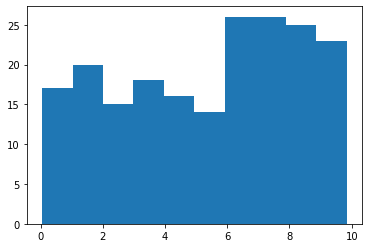

In [19]:
lambdas = np.array([i['Lambda'].detach().numpy() for i in leaf_results])
plt.hist(lambdas)
plt.show()